# Tutorial 5a: Credible regions

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t5a_credible_regions.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/t5a_credible_regions.ipynb).*

In [1]:
import collections

import numpy as np
import numba
import pandas as pd
import scipy.stats as st

import emcee
import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

Performing MCMC calculations gives you full information about the posterior, which you can summarize in beautiful and informative corner plots. But, very often, we wish to summarize the posterior in a few simple numbers. In particular, we wish to report a **credible region**, the Bayesian analog to a confidence interval. The credible region is a region in parameter space where we might expect a parameter value to lie. This credible region is often reported and plotted as an error bar.

We will consider three commonly used ways of plotting a value plus error bar.  We will use a 95% credible region for this demonstration.

1. **mean $\pm$ standard deviation**: The most commonly used confidence interval is $\mu \pm k\sigma$, where $k$ is chosen to give the appropriate confidence interval, assuming the posterior is Gaussian.  We'll do 95%, which means $k = 1.96$.
2. **median with quantile**: The posterior need not be Gaussian.  If it is not, we would like a more robust way to summarize it.  A simple method is to report the median, and then give lower and upper bounds to the error bar based on quantile.  In our case, we would report the 2.5th percentile and the 97.5th percentile.
3. **mode with HPD**: This method uses the **highest posterior density** interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior.  So, we report the mode (the most probable parameter value) and then the bounds on the HPD interval.

To illustrate the relative merits of these reporting schemes, we'll draw MCMC samples out of some artificial distributions.

## Some distributions to sample

We will generate some sample distributions to sample using MCMC.  We will consider an exponential distribution, a Gaussian, the sum of two Gaussians, and a distribution with a long tail.  We choose these to illustrate how various choices of the credible region will be reported.

In [2]:
@numba.jit(nopython=True)
def log_exp(x, lam):
    """
    Log of unnormalized exponential distribution with a given lambda.
    """
    if x[0] < 0:
        return -np.inf
    
    return -lam * x[0]


@numba.jit(nopython=True)
def log_gauss(x, mu, sigma):
    """
    Log of unnormalized exponential distribution with a given mu, sigma.
    """
    return -(x[0] - mu)**2 / 2.0 / sigma**2


@numba.jit(nopython=True)
def log_sum_of_gauss(x, mu_1, mu_2, sigma_1, sigma_2):
    """
    Log of sum of Gaussians.
    """
    gauss_1 = np.exp(-(x[0] - mu_1)**2 / 2.0 / sigma_1**2) \
                    / np.sqrt(2.0 * np.pi) / sigma_1
    gauss_2 = np.exp(-(x[0] - mu_2)**2 / 2.0 / sigma_2**2) \
                    / np.sqrt(2.0 * np.pi) / sigma_2
    return np.log(gauss_1 + gauss_2)


@numba.jit(nopython=True)
def log_longtail(x, mu, sigma):
    """
    Log of unnormalized lognormal distribution.
    """
    if x[0] <= 0.0:
        return -np.inf
    
    return np.log(x[0] / (x[0] + 5.0)**5)

## Generation of MCMC samples

We'll use MCMC to sample these to get chains.

In [3]:
# Parametrize dists
lam = 1.0
mu = 1.0
sigma = 0.25
mu_2 = 3.0
sigma_2 = 0.5

# Seed random number generator for reproducibility
np.random.seed(42)

# Parameter name and starting point
p_dict = collections.OrderedDict([('x', (np.random.uniform, (0.1, 2.0)))])

# names, functions, and arguments
names = ['exponential', 'Gaussian', '2 Gaussians', 'long tail']
funcs = [log_exp, log_gauss, log_sum_of_gauss, log_longtail]
args_list = [(lam,), (mu, sigma), (mu, mu_2, sigma, sigma_2), (mu, sigma)]

# DataFrame to store samples
df = pd.DataFrame()

# Perform MCMC calcs and store
for name, func, args in zip(names, funcs, args_list):
    df_mcmc = bebi103.run_ensemble_emcee(
        log_post=func, n_burn=5000, n_steps=5000, n_walkers=10, p_dict=p_dict,
        args=args)
    df[name] = df_mcmc['x']
    df[name + '_lnprob'] = df_mcmc['lnprob']

In [5]:
df

,exponential,exponential_lnprob,Gaussian,Gaussian_lnprob,2 Gaussians,2 Gaussians_lnprob,long tail,long tail_lnprob
0,0.546374,-0.546374,0.908300,-0.067271,0.969555,0.460073,1.689061,-8.978195
1,0.709043,-0.709043,0.908761,-0.066597,1.044505,0.451753,0.845755,-8.996104
2,0.675438,-0.675438,0.908761,-0.066597,1.044505,0.451753,0.845755,-8.996104
3,0.673435,-0.673435,0.957608,-0.014376,1.044505,0.451753,2.112885,-9.061485
4,0.546132,-0.546132,0.773863,-0.409102,1.044505,0.451753,2.131427,-9.065765
5,0.545820,-0.545820,0.773863,-0.409102,1.044505,0.451753,2.728128,-9.220718
6,0.556434,-0.556434,0.538828,-1.701441,1.097354,0.391921,2.740673,-9.224240
7,0.488529,-0.488529,0.443895,-2.474020,0.882085,0.356195,2.740673,-9.224240
8,0.170201,-0.170201,0.436853,-2.537078,0.882085,0.356195,4.062130,-9.618814
9,0.170201,-0.170201,0.436853,-2.537078,0.882085,0.356195,2.254126,-9.095090


Let's look at what we got from MCMC.

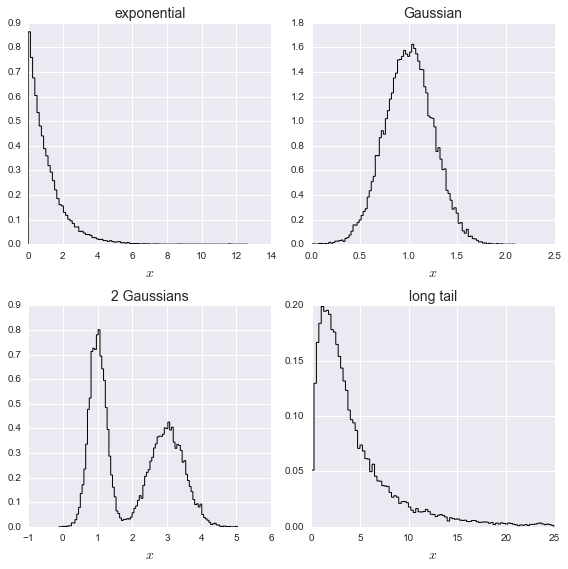

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sps = [(0,0), (0,1), (1,0), (1,1)]
for i, name in enumerate(names):
    # In case of long tail, only keep smaller values
    inds = df[name] < 25.0

    # Make histogram
    n, b, p = ax[sps[i]].hist(df.loc[inds, name], histtype='step', 
                              color='black', normed=True, bins=100, lw=1)
    
    # Plot labeling
    ax[sps[i]].set_xlabel(r'$x$', fontsize=14)
    ax[sps[i]].set_title(name)
plt.tight_layout()

## Summarizing the MCMC results with error bars

We'll start by computing the mean, standard deviation, median, and quantiles, since these are easy to compute with NumPy.

In [6]:
# DataFrame to store summary stats
df_summary = pd.DataFrame(index=['mean', 'std', '2.5', 'median', '97.5', 
                                 'mode', 'hpd_low', 'hpd_high'],
                          columns=names)

for name in names:
    df_summary.loc['mean', name] = np.mean(df.loc[:,name])
    df_summary.loc['std', name] = np.std(df.loc[:,name])
    df_summary.loc[['2.5', 'median', '97.5'], name] = np.percentile(
        df.loc[:,name], [2.5, 50, 97.5])

Computation of the HPD is a little trickier.  The function below will compute the HPD interval.  The idea is that we rank-order the MCMC trace.  We know that the number of samples that are included in the HPD is 0.95 times the total number of MCMC sample.  We then consider all intervals that contain that many samples and find the shortest one. This function is included in `bebi103_utils`, but I include it here for reference.

In [7]:
def hpd(trace, mass_frac) :
    """
    Returns highest probability density region given by
    a set of samples.

    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
        
    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

With this function in hand, we can compute the HPD and get the modes and error bars.

In [8]:
for name in names:
    df_summary.loc['mode', name] = \
                    df.loc[np.argmax(df.loc[:, name + '_lnprob']), name]
    df_summary.loc[['hpd_low', 'hpd_high'], name] = hpd(df[name], 0.95)

Now that we have computed all of the summaries, we can plot them with error bars on the original distributions.

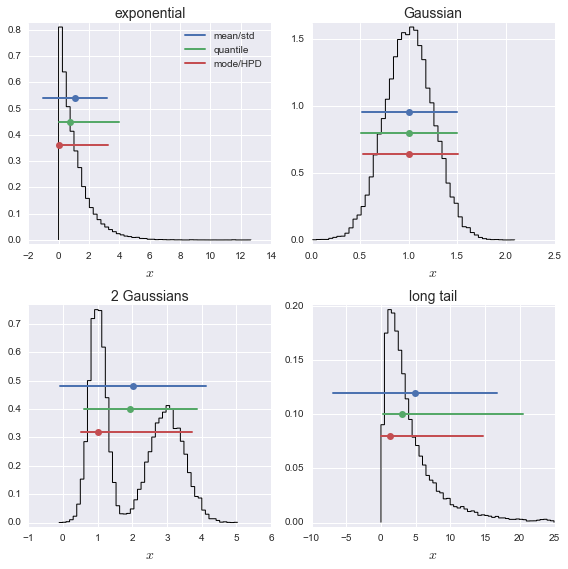

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sps = [(0,0), (0,1), (1,0), (1,1)]
for i, name in enumerate(names):
    # In case of long tail, only keep smaller values
    inds = df[name] < 25.0

    # Make histogram
    n, b, p = ax[sps[i]].hist(df.loc[inds, name], histtype='step', 
                              color='black', normed=True, bins=50, lw=1,
                              label=None)
    
    # Get y-value for Gaussian error bar
    ylims = ax[sps[i]].get_ylim()
    y_gauss = ylims[1] / 2.0 + ylims[1] * 0.1

    # Get y-value for quantile error bar
    y_quantile = ylims[1] / 2.0
    
    # Get y-value for HPD error bar
    y_hpd = ylims[1] / 2.0 - ylims[1] * 0.1

    # Plot Gaussian error bar
    mean = df_summary.loc['mean', name]
    std = df_summary.loc['std', name]
    dot, = ax[sps[i]].plot(mean, y_gauss, 'o')
    ax[sps[i]].plot([mean - 1.96 * std, mean + 1.96 * std], 
                    [y_gauss, y_gauss], '-', color=dot.get_color(),
                    label='mean/std')

    # Plot quantile error bar
    low = df_summary.loc['2.5', name]
    median = df_summary.loc['median', name]
    high = df_summary.loc['97.5', name]
    dot, = ax[sps[i]].plot(median, y_quantile, 'o')
    ax[sps[i]].plot([low, high], [y_quantile, y_quantile], '-', 
                    color=dot.get_color(), label='quantile')
    
    # Plot HPD error bar
    low = df_summary.loc['hpd_low', name]
    high = df_summary.loc['hpd_high', name]
    mode = df_summary.loc['mode', name]
    dot, = ax[sps[i]].plot(mode, y_hpd, 'o')
    ax[sps[i]].plot([low, high], [y_hpd, y_hpd], '-', 
                    color=dot.get_color(), label='mode/HPD')
    
    # Plot labeling
    ax[sps[i]].set_xlabel(r'$x$', fontsize=14)
    ax[sps[i]].set_title(name)
    ax[sps[i]].set_ylim((-0.02*np.max(n), np.max(n)*1.02))

ax[0,0].legend(loc='upper right')
plt.tight_layout()

## Relative merits of each method

* The mean/std does not respect bounds on the posterior, nor any asymmetry. Unless we are going for speed and using a MAP finder/Gaussian approximation, there is no need for this method or summarizing the posterior.
* The primary advantage of the quantile approach is that it is very easy to interpret, especially for the researcher uninitiated to Bayesian statistics. It does not suffer from the problems that the mean/std method does. It does not rely on any approximations.
* The HPD method gives just that: where the parameter value is most likely to fall, which is not necessarily the interquantile region with the median at its center. It is also nice to know the most probable parameter value. The drawback is the possible difficulty of interpretability for the uninitiated.

In any case, attempting to describe a multi-modal posterior with an error bar is misleading and futile.

## How to display the summary in text.

One issue that may be worrying you is how to report the asymmetric error bars in text. This is best seen by example. For the example of the long tailed, we may report the mode with HPD as $1.25^{+13.56}_{-1.22}$.